# Performance of LSH for coreferences

In [21]:
from load_coreferences import load_coreferences, load_pairs
import lsh 
import copy
import numpy as np
import time 
import matplotlib.pyplot as plt

import cProfile

scaling_factor = 5 # multiply size the original data set by this factor

In [2]:
all_pairs = load_pairs()
raw_mentions = load_coreferences()
mentions = {i: m for i, m in enumerate(raw_mentions)}


#### Effectiveness

In [8]:
def evaluate_coref_predictions(pairs_gold, candidates, _return = False):
    "Precision and recall for LSH coref pair search"
    missed = 0 
    correct = 0 
    wrong = 0

    for mention, true_reference in pairs_gold.items():
        current_candidates = candidates[mention]

        if true_reference not in current_candidates:
            missed += 1
        for candidate in current_candidates:
            if candidate == true_reference:
                correct += 1
            elif candidate != true_reference:
                wrong += 1


    precision = correct / (correct + wrong)
    recall = correct / (correct + missed)

    ndig = 3
    if not _return:
        print(f"Precision: {round(precision, ndig)}") # note: lower precision means larger comparison set for coref classification.
        print(f"Recall: {round(recall, ndig)}") 
    else:
        return (precision, recall)

In [4]:
pairs_gold = {}
for pair_doc in all_pairs.values():
    for p in pair_doc:
        pairs_gold[p[1]] = p[0] # key = mention, value = true coreference



In [59]:
mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=4, signature_size=300, band_length=2)

mylsh.cluster()
mylsh.summarise()
candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]]  for idx, mention in mentions.items()}

evaluate_coref_predictions(pairs_gold, candidates)


took 0.32034993171691895 seconds for 174 mentions
average, min, max cluster size: 1.62, 1, 5
Precision: 0.731
Recall: 1.0


Properties    
- longer signature $\rightarrow$ higher recall, lower precision
- larger shingle $\rightarrow$ lower recall, higher precision
- longer band $\rightarrow$ lower recall, higher precision


In [52]:

max_signature_size = 300
min_signature_size = 20
# band_lengths = [2, 3, 4] # varying band lengths gives not strictly increasing ROC curve
band_lengths = [2]
shingle_sizes = [2,3,4]

measure_dict = {}

for shingle_size in shingle_sizes:
    l = band_lengths[0]
    measurements = []
    start_size = min_signature_size - (min_signature_size % l) + l # start at next multiple of l
    for s in range(start_size, max_signature_size, l):
        mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=shingle_size, signature_size=s, band_length=l)

        mylsh.cluster()
        candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]]  for idx, mention in mentions.items()}

        m = evaluate_coref_predictions(pairs_gold, candidates, _return=True)
        measurements.append(m)
    measure_dict[shingle_size] = measurements


In [53]:
md = {k: [
    [1 - i[0] for i in measures], # fpr
    [i[1] for i in measures] # recall
] for k, measures in measure_dict.items()}


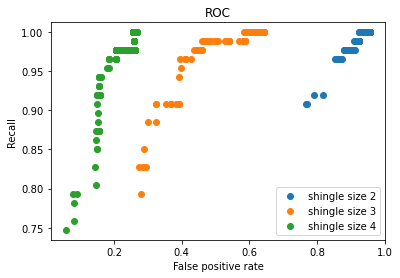

In [54]:
fig, ax = plt.subplots()
for k, v in md.items():
    lbl = f"shingle size {k}"
    ax.scatter(x=v[0], y=v[1], label=lbl)

ax.set_xlabel("False positive rate")
ax.set_ylabel("Recall")
ax.set_title("ROC")
ax.legend()

Notes 
- trade off: get the same recall for smaller false positive rate with larger shingle size, but need a larger signature and thus more time 
    - improve the calculation of the signature?
    - another benefit however is that with a smaller false positive rate, the `with_coref` call in REL will be faster (smaller comparison sets)
    - also important: higher false positive rate means more comparisons also for those mentions that are *not* coreferences (and are not in the present dataset).
- add color shading for shinge size? -- 

#### Profiling

In [60]:

# stack mentions on top of each other 
mentions_scaled = copy.copy(mentions)

idx = len(mentions_scaled)
for i in range(1, scaling_factor):
    for idx_old in mentions.keys():
        m = mentions[idx_old]
        mentions_scaled[idx] = m 
        idx += 1

In [61]:
mylsh = lsh.LSHMinHash_nonp(mentions=mentions_scaled, shingle_size=4, signature_size=300, n_buckets=2)
cProfile.run("mylsh.cluster()")

         1576738 function calls in 6.023 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.023    6.023 <string>:1(<module>)
        1    1.901    1.901    2.086    2.086 lsh.py:155(_min_hash)
        1    0.000    0.000    0.000    0.000 lsh.py:156(<dictcomp>)
        1    0.000    0.000    0.071    0.071 lsh.py:178(_make_bands)
        1    3.778    3.778    3.780    3.780 lsh.py:183(_make_clusters)
        1    0.000    0.000    0.000    0.000 lsh.py:184(<dictcomp>)
      870    0.066    0.000    0.071    0.000 lsh.py:19(partition_signature)
        1    0.000    0.000    6.023    6.023 lsh.py:203(cluster)
        1    0.000    0.000    0.000    0.000 lsh.py:78(_build_vocab)
        1    0.000    0.000    0.000    0.000 lsh.py:79(<listcomp>)
        1    0.000    0.000    0.000    0.000 lsh.py:80(<listcomp>)
        1    0.001    0.001    0.086    0.086 lsh.py:83(encode_binary)
      870   

In [62]:
mylsh = lsh.LSHMinHash(mentions=mentions_scaled, shingle_size=4, signature_size=300, band_length=2)

cProfile.run("mylsh.cluster()")

         855109 function calls (830856 primitive calls) in 1.491 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      150    0.000    0.000    0.005    0.000 <__array_function__ internals>:2(argsort)
      151    0.000    0.000    0.043    0.000 <__array_function__ internals>:2(array_split)
      153    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(concatenate)
      150    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
      300    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(cumsum)
      150    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(diff)
      300    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(empty_like)
      300    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(fliplr)
      300    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(ndim)
      150    0.000    0.000   

#### Time analysis for sorting multidimensional array along one axis

In [ ]:
# keep this for some time analysis
    # mult before sort -- adapt from the now helper function cols_to_int
x = np.array([[0, 3], [2, 2], [2, 2], [0, 3]]) 
x = np.array([[1, 3], [2, 2], [2, 2], [1, 3], [1, 5], [1, 1]]) # this is one test case
A = np.array([[3,4], [3,5], [5,6], [3,4], [6,7]]) # this is another test case

display(A)
display(np.argsort(A, axis=0))
display(A.view('i8,i8').argsort(order=['f1'], axis=0))

display(x)
display(np.argsort(x, axis=0))
display(x.view('i8,i8').argsort(order=['f1'], axis=0))


n = 100_000
A = np.random.choice(np.arange(int(n/100)), size=(n,2))
%timeit np.argsort(A, axis=0)
%timeit A.view('i8,i8').argsort(order=['f1'], axis=0)
%timeit mult_before_sort(A)